In [1]:
import torch

In [2]:
import urllib.request
import ssl
import zipfile
import os
from pathlib import Path

## Finetuning For Classification

#### Download the dataset

In [3]:
import urllib.request
import ssl
import zipfile
import os
from pathlib import Path


url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f'{data_file_path} already exists. Skipping download and extraction')
        return

    # Create an unverified SSL context
    ssl_context = ssl._create_unverified_context()

    # Downloading the file
    with urllib.request.urlopen(url, context=ssl_context) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    # Unzipping the file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    # Add .tsv file exeptension
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f'File downloaded and saved as {data_file_path}')


download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)


sms_spam_collection\SMSSpamCollection.tsv already exists. Skipping download and extraction


In [5]:
import pandas as pd

extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"
df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])

df.head()

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [14]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


In [10]:
def create_balanced_dataset(df):
    ham = df[df["Label"] == "ham"]
    spam = df[df["Label"] == "spam"]

    ham = ham.sample(n=len(spam), random_state=42)

    return pd.concat([ham, spam]).reset_index(drop=True)

balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


In [11]:
balanced_df.head()

,Label,Text
0,ham,If i not meeting ü all rite then i'll go home ...
1,ham,"I.ll always be there, even if its just in spir..."
2,ham,"Sorry that took so long, omw now"
3,ham,I thk 50 shd be ok he said plus minus 10.. Did...
4,ham,Dunno i juz askin cos i got a card got 20% off...


In [12]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})
balanced_df.head()

,Label,Text
0,0,If i not meeting ü all rite then i'll go home ...
1,0,"I.ll always be there, even if its just in spir..."
2,0,"Sorry that took so long, omw now"
3,0,I thk 50 shd be ok he said plus minus 10.. Did...
4,0,Dunno i juz askin cos i got a card got 20% off...


In [55]:
balanced_df.shape

(1494, 2)

In [14]:
# 70% train, 10% validation, 20% test

def random_split(df, train_frac, validation_frac):
    # Shuffle the entire dataframe
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)

    # Calculate split indices
    train_end = int(train_frac * len(df))
    validation_end = int(validation_frac * len(df)) + train_end

    # Split the Shuffled data
    train_df = df[:train_end]
    validation_df = df[train_end : validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df



train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)

In [15]:
train_end = int(0.7 * len(balanced_df))
validation_end = int(0.1 * len(balanced_df)) + train_end

print("train_end :",train_end) 
print("validation_end :",validation_end )


train_end : 1045
validation_end : 1194


In [16]:
len(train_df), len(validation_df), len(test_df)

(1045, 149, 300)

In [17]:
# train_df.to_csv(r"sms_spam_collection\train.csv", index=None)
# validation_df.to_csv(r"sms_spam_collection\validation.csv", index=None)
# test_df.to_csv(r"sms_spam_collection\test.csv", index=None)

#### Creating Dataloaders

In [18]:
import torch
from torch.utils.data import Dataset

# Prepare data into input-target pairs
class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)

        # Pre-tokenized texts
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data['Text']
            ]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length

            # Truncate sequences if they are longer than max_length
            self.encoded_texts = [
                encoded_text[:self.max_length] for encoded_text in self.encoded_texts
            ]
        
        # Pad sequences to the longest sequence
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text)) for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]['Label']
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length


In [19]:
import tiktoken


tokenizer = tiktoken.get_encoding("gpt2")

train_dataset = SpamDataset(
    csv_file=r"sms_spam_collection\train.csv",
    max_length=None,
    tokenizer=tokenizer
)

print(train_dataset.max_length) # since the longest seq in the data

120


In [20]:
val_dataset = SpamDataset(
    csv_file=r"sms_spam_collection\validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file=r"sms_spam_collection\test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)


print(val_dataset.max_length) 
print(test_dataset.max_length) 


120
120


In [21]:
# using the datasets as inputs, we can instantiate the data loaders

from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True # if the last batch has a smaller data 
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False
)

In [22]:
print("Train loader:")
for input_batch, target_batch in train_loader:
    pass

print('Input batch dim:', input_batch.shape)
print('Label batch dim:', target_batch.shape)
# every input batch has 8 rows and 120 cols

Train loader:
Input batch dim: torch.Size([8, 120])
Label batch dim: torch.Size([8])


In [23]:
print(f'{len(train_loader)} training batches') # df_train.shape[0]/8
print(f'{len(val_loader)} validation batches')
print(f'{len(test_loader)} test batches')

130 training batches
19 validation batches
38 test batches


In [24]:
print(train_df.shape[0]/8)
print(validation_df.shape[0]/8)
print(test_df.shape[0]/8)

130.625
18.625
37.5


### Step 1: Initializing a Model With Pre-Trained weights

In [74]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    'vocab_size': 50257,
    'context_length': 1024,
    'drop_rate': 0.0,
    'qkv_bias': True,
}
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25}
}
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

assert train_dataset.max_length <= BASE_CONFIG['context_length'], (
    f"Dataset length {train_dataset.max_length} exceeds model's context"
    f"length {BASE_CONFIG['context_length']}. Reinitialize the dataset with"
    f"`max_length = {BASE_CONFIG['context_length']}`"
)


In [75]:
import numpy as np

def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shapes mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))


def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params['blocks'][b]['attn']['c_attn'])['w'], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)
        
        q_b, k_b, v_b = np.split(
            (params['blocks'][b]['attn']['c_attn'])['b'], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)
        
        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight, 
            params['blocks'][b]['attn']['c_proj']['w'].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias, 
            params['blocks'][b]['attn']['c_proj']['b'])
        
        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight, 
            params['blocks'][b]['mlp']['c_fc']['w'].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, 
            params['blocks'][b]['mlp']['c_fc']['b'])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight, 
            params['blocks'][b]['mlp']['c_proj']['w'].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias, 
            params['blocks'][b]['mlp']['c_proj']['b'])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, 
            params['blocks'][b]['ln_1']['g'])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params['blocks'][b]['ln_1']['b'])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, 
            params['blocks'][b]['ln_2']['g'])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params['blocks'][b]['ln_2']['b'])
        
    gpt.final_norm.scale = assign(gpt.final_norm.scale, params['g'])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params['b'])
    gpt.out_head.weight = assign(gpt.out_head.weight, params['wte'])


In [76]:
CHOOSE_MODEL

'gpt2-small (124M)'

In [77]:
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip('(').rstrip(')')

from gpt_download3 import download_and_load_gpt2
from modules import GPTModel

settings, params = download_and_load_gpt2(model_size, models_dir='gpt2')

# Update BASE_CONFIG with the correct vocabulary size
BASE_CONFIG['vocab_size'] = settings['n_vocab']

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

c:\Users\pc\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2\124M\checkpoint


c:\Users\pc\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2\124M\encoder.json


c:\Users\pc\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2\124M\hparams.json


c:\Users\pc\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2\124M\model.ckpt.data-00000-of-00001


c:\Users\pc\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2\124M\model.ckpt.index


c:\Users\pc\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2\124M\model.ckpt.meta


c:\Users\pc\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2\124M\vocab.bpe


#### Test text generation 

In [78]:
# the model loaded correctly, lets test it
from modules import text_to_token_ids, token_ids_to_text, generate_text_simple


text_1 = "Every effort moves you"

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG['context_length'],
)

print('Output text:\n', token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you forward.

The first step is to understand the importance of your work


In [31]:
# the model loaded correctly, lets test it
from modules import text_to_token_ids, token_ids_to_text, generate_text_simple


text_1 = "Every effort moves you"

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG['context_length'],
)

print('Output text:\n', token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you forward.

The first step is to understand the importance of your work


' '

- Finetune with our spam dataset (Finetune as a spam classifier)
-
- But before that, lets see if the model can perhaps already classify spam messages by prompting it with instructions

In [79]:
# lets see if the model can perhaps already classify spam messages by prompting it with instructions

text_2 = (
    "Is the following text 'spam' Answer with 'yes' or 'no': "
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or $2000 award.' "
)

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG['context_length'],
)

print('Output text:\n', token_ids_to_text(token_ids, tokenizer))

Output text:
 Is the following text 'spam' Answer with 'yes' or 'no':  'You are a winner you have been specially selected to receive $1000 cash or $2000 award.'  'You have been specially selected to receive $1000 cash or $2000 award


### Step 2: Adding a Classification Data

- We will Finetune :
    - Final Output Head
    - Final Transformer Block
    - Final Layer Norm 

In [33]:
# modify the output shape for instead of predict the dim of the next word, we will do the same thing but the output dim will change the model will classify (just two output yes/no)

In [59]:
# we observe that the model contains 12 transformer blocks, each with a multi-head self-attention mechanism and a feedforward neural network. The model also has a final layer normalization and a linear output head.
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcuts): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=

- We replace the output head (out_head) with a new output layer that has two output units

In [80]:
# we first freeze the model, meaning that we make all layers non-trainable

for param in model.parameters():
    param.requires_grad = False

In [81]:
# maps 50257 to num_classes=2 (spam or ham)

torch.manual_seed(123)

num_classes = 2
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG['emb_dim'], out_features=num_classes)

In [37]:
# we can now train the model

for params in model.trf_blocks[-1].parameters():
    params.requires_grad = True

for params in model.final_norm.parameters():
    params.requires_grad = True

In [82]:
inputs = tokenizer.encode("Do you have time")

inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Inputs dim:", model(inputs).shape) #  (batch_size, num_toknes)

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dim: torch.Size([1, 4, 2])


In [83]:
with torch.no_grad():
    outputs = model(inputs)

print("Outputs:\n", outputs)
print("Outputs dim:", outputs.shape) # (batch_size, num_classes)

Outputs:
 tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]])
Outputs dim: torch.Size([1, 4, 2])


In [84]:
# we will focus on the last row corresponding to the last token in the input sequence (its contains all the infos about the other tokens)
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-3.5983,  3.9902]])


''

### Calculating The Classification Loss and Accuracy

In [63]:
print("Last output token:", outputs[:, -1, :])

probas = torch.softmax(outputs[:, -1, :], dim=-1)
print(probas)
label = torch.argmax(probas)
print("Class label:", label.item())

Last output token: tensor([[-3.5983,  3.9902]])
tensor([[5.0598e-04, 9.9949e-01]])
Class label: 1


In [64]:
# Or
logits = outputs[:, -1, :]
label = torch.argmax(logits)
print("Class label:", label.item())

Class label: 1


In [65]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions = 0
    num_examples = 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples


In [44]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
torch.manual_seed(123)

train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy}")
print(f"Validation accuracy: {val_accuracy}")
print(f"Test accuracy: {test_accuracy}")

Training accuracy: 0.4625
Validation accuracy: 0.45
Test accuracy: 0.4875


In [45]:
print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


In [46]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :]
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

In [47]:
# same as before 
# compute loss for a user specified number of batches
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float('nan')
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data 
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [69]:
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)


print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 13.655
Validation loss: 13.835
Test loss: 13.381


'

### Finetuning The Model On Supervised Data
- The Training Loop

In [70]:
# Calculate the loss over the training and validation set while ensuring the model is in evaluation mode with gradient tracking 
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval() # dropout disable
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [71]:
# Overall the as 'train_model_simple' in prev chapter
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter):

    # Initialize lists to track losses and examples seen
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    examples_seen = 0
    global_step = -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train() # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss grads
            examples_seen += input_batch.shape[0] # New : track examples instead of toknes
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f'Ep {epoch+1} (Step {global_step:06d}): '
                      f'Train loss {train_loss:.3f}, Val loss {val_loss:.3f}')
                
        # Calculate accuracy after each epoch
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}%", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)
    
    return train_losses, val_losses, train_accs, val_accs, examples_seen


In [136]:
import time 

start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 5 
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device, num_epochs=num_epochs, eval_freq=50, eval_iter=5
)
 
# every after each batches printing the training and validation loss
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f'Training completed in {execution_time_minutes:.2f} minutes')

Ep 1 (Step 000000): Train loss 2.160, Val loss 2.374
Ep 1 (Step 000050): Train loss 0.654, Val loss 0.631
Ep 1 (Step 000100): Train loss 0.531, Val loss 0.566
Training accuracy: 85.00%Validation accuracy: 75.00%
Ep 2 (Step 000150): Train loss 0.572, Val loss 0.513
Ep 2 (Step 000200): Train loss 0.283, Val loss 0.387
Ep 2 (Step 000250): Train loss 0.548, Val loss 0.334
Training accuracy: 87.50%Validation accuracy: 72.50%
Ep 3 (Step 000300): Train loss 0.312, Val loss 0.323
Ep 3 (Step 000350): Train loss 0.371, Val loss 0.241
Training accuracy: 90.00%Validation accuracy: 92.50%
Ep 4 (Step 000400): Train loss 0.115, Val loss 0.201
Ep 4 (Step 000450): Train loss 0.034, Val loss 0.108
Ep 4 (Step 000500): Train loss 0.409, Val loss 0.065
Training accuracy: 97.50%Validation accuracy: 97.50%
Ep 5 (Step 000550): Train loss 0.201, Val loss 0.052
Ep 5 (Step 000600): Train loss 0.071, Val loss 0.055
Training accuracy: 100.00%Validation accuracy: 97.50%
Training completed in 53.61 minutes


In [49]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, label=f"Validation {label}", linestyle='-.')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend(label.capitalize())

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny() # 2nd x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0) # invivible plot
    ax2.set_xlabel('Examples seen')

    fig.tight_layout() # Adjust layout to make soom
    plt.show()


In [ ]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen, train_losses, val_losses)

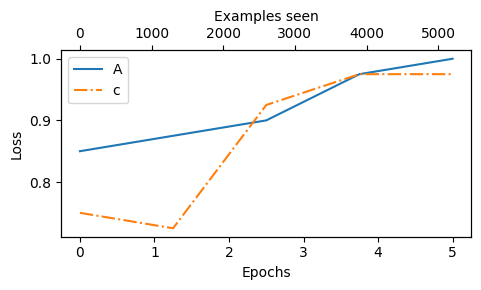

In [139]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

In [ ]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

### Save the Finetuned model

In [141]:
torch.save(model.state_dict(), "review_classifier.pth")

### Load the Finetuned model

In [85]:
model_state_dict = torch.load("review_classifier.pth")
model.load_state_dict(model_state_dict)

C:\Users\pc\AppData\Local\Temp\ipykernel_10008\379311099.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load("review_classifier.pth")


<All keys matched successfully>

### Using the LLM as A Spam Classifier
- Use the model on new data

In [94]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()

    # Prepare inputs to the model
    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[0]

    # Truncate sequences if they too long
    input_ids = input_ids[:min(max_length, supported_context_length)]

    # Pad seq to the longest seq
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0) # add batch dimension

    # Model infzrence
    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :] # Logits of the output token
    predicted_label = torch.argmax(logits, dim=-1).item()

    return "spam" if predicted_label == 1 else "not spam"


In [98]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or $2000 award."
)

print(classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

spam


In [97]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight. Let me know!"
)

print(classify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

not spam
